In [126]:
import os
import pickle
from collections import defaultdict
from typing import Union

import matplotlib.pyplot as plt
import mne
import numpy as np
from imblearn.over_sampling import SMOTE
from mne.viz import plot_topomap
from scipy import stats
import torch
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})


# Understand Transformer as Kernels: The math&code of physio transformers

## Transformer Preliminaries
Given an input token sequence
$$
\mathbf{x}=[x_1, x_2, ..., x_n]
$$
Drawn from a token space $\mathcal{X}$

This will be our tokens representing a signal

In [144]:
n_epochs = 10
num_channels = 8  # AFz, Fz, FCz, Cz, CPz, Pz, POz, Oz
sampling_rate = 200  # Hz
epoch_duration = 0.9  # seconds

num_timesteps = int(sampling_rate * epoch_duration)  # t

x_eeg = torch.randn(n_epochs, num_channels, num_timesteps)  # (n_epochs, num_channels, num_timesteps)
print(f'{x_eeg.shape = }')

x_eeg.shape = torch.Size([10, 8, 180])


Now let's turn the EEG signal into tokens, we will do this by windowing the signal.

In [146]:
window_duration = 0.1
token_length = int(window_duration * sampling_rate)  # tau

token_embed_dim = 64
token_embedding = nn.Sequential(
    Rearrange('b c t -> b 1 c t', c=num_channels, t=num_timesteps),  # b is the number of epochs
    nn.Conv2d(1, token_embed_dim, kernel_size=(1, token_length), stride=(1, token_length), bias=True),
)

x_token = token_embedding(x_eeg)  # (n_epochs, token_embed_dim, num_channels, num_timesteps)
print(f'before merging the time and channel axes {x_token.shape = }')
x_token = x_token.flatten(2)  # (n_epochs, token_embed_dim, num_tokens)
x_token = x_token.transpose(1, 2) # (n_epochs, num_tokens, token_embed_dim)
print(f'after merging the time and channel axes, and swapping n_tokens and d_embed {x_token.shape = }')
num_tokens = x_token.shape[1]

before merging the time and channel axes x_token.shape = torch.Size([10, 64, 8, 9])
after merging the time and channel axes, and swapping n_tokens and d_embed x_token.shape = torch.Size([10, 72, 64])


Token embeddings are then fed into a Transformer block, with QKV projections.

In [149]:
dim_head = 64
n_head = 3
#
to_qkv = nn.Linear(token_embed_dim, dim_head * n_head * 3, bias=False)  # qkv does not include bias  W: (d_{embed}, n_{head} * d_{head} * 3)
to_out = nn.Linear(dim_head * n_head, token_embed_dim)  # W: (n_{head} * d_{head} * 3, d_{embed})

print(f'{to_qkv.weight.data.shape = }')
print(f'{to_out.weight.data.shape = }')

to_qkv.weight.data.shape = torch.Size([576, 64])
to_out.weight.data.shape = torch.Size([64, 192])


Apply the QKV and out projection to the token embeddings

In [150]:
qkv = to_qkv(x_token).chunk(3, dim=-1)
q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=n_head), qkv)

print(f'{q.shape = }')

dots = torch.einsum('bhid,bhjd->bhij', q, k)  # dot product between each query key pair (n_epochs, n_head, num_tokens, num_tokens)
print(f'{dots.shape = }')

attention = nn.Softmax(dim=-1)(dots * dim_head ** -0.5)  # (n_epochs, n_head, num_tokens, num_tokens)


q.shape = torch.Size([10, 3, 72, 64])
dots.shape = torch.Size([10, 3, 72, 72])


In [151]:
attented = torch.torch.einsum('bhij,bhjd->bhid', (attention, v))  # (n_epochs, n_head, num_tokens, d_head)
print(f'{attented.shape = }')

attented = rearrange(attented, 'b h n d -> b n (h d)')
print(f'after merging all heads {attented.shape = }')

out = to_out(attented)  # (n_epochs, num_tokens, token_embed_dim)
print(f'{out.shape = } The same shape as our input token embeddings {x_token.shape = }')

attented.shape = torch.Size([10, 3, 72, 64])
after merging all heads attented.shape = torch.Size([10, 72, 192])
out.shape = torch.Size([10, 72, 64]) The same shape as our input token embeddings x_token.shape = torch.Size([10, 72, 64])


## Nadaraya-Watson kernel-weighted average as Kernel Smoother

In [152]:

def nadaraya_watson_kernel_smoother(x, x_data, y_data, kernel_func):
    """
    Nadaraya-Watson kernel weighted average (kernel smoother) implementation.

    Arguments:
    x -- The input value(s) for which the prediction is made (can be a scalar or an array).
    x_data -- The array of input values in the training dataset.
    y_data -- The array of output values in the training dataset.
    kernel_func -- The kernel function to compute the weights.

    Returns:
    The predicted value(s) based on the Nadaraya-Watson kernel weighted average.
    """
    numerator = 0.0
    denominator = 0.0

    for i in range(len(x_data)):
        kernel_weight = kernel_func(x, x_data[i])
        numerator += kernel_weight * y_data[i]
        denominator += kernel_weight

    return numerator / denominator

Define a few different kernels

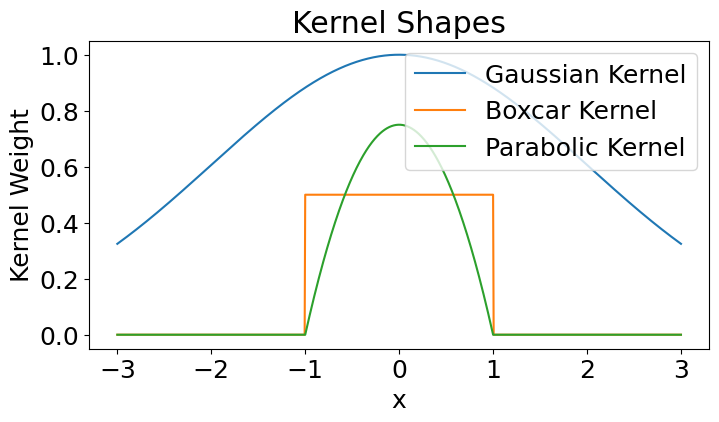

In [153]:
# Gaussian kernel function
def gaussian_kernel(x, xi, bandwidth=2):
    return np.exp(-(x - xi) ** 2 / (2 * bandwidth ** 2))

def boxcar_kernel(x, xi, bandwidth=2):
    return np.where(np.abs(x - xi) <= bandwidth/2, 1/bandwidth, 0)

def parabolic_kernel(x, xi, bandwidth=2):
    return np.where(np.abs(x - xi) <= bandwidth/2, 0.75 * (1 - ((x - xi) / (bandwidth/2))**2), 0)

x = np.linspace(-3, 3, num=1000)  # x-axis values

# Compute kernel shapes for each kernel function
gaussian_shape = gaussian_kernel(x, 0)
boxcar_shape = boxcar_kernel(x, 0)
parabolic_shape = parabolic_kernel(x, 0)

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(x, gaussian_shape, label='Gaussian Kernel')
plt.plot(x, boxcar_shape, label='Boxcar Kernel')
plt.plot(x, parabolic_shape, label='Parabolic Kernel')
plt.xlabel('x')
plt.ylabel('Kernel Weight')
plt.title('Kernel Shapes')
plt.legend()
plt.show()

In [134]:
def generate_sparse_sin_data(n_samples, noise_std=0.1):
    """
    Generate sparse sinusoidal dummy data.

    Arguments:
    n_samples -- Number of samples to generate.
    noise_std -- Standard deviation of Gaussian noise added to the samples.

    Returns:
    x -- Input values with sparsely sampled points.
    y -- Corresponding output values of the sine function with added noise.
    """
    x_sparse = np.sort(np.random.choice(np.arange(0, 2*np.pi, 0.2), size=n_samples, replace=False))
    y_sparse = np.sin(x_sparse) + np.random.normal(0, noise_std, size=n_samples)
    return x_sparse, y_sparse

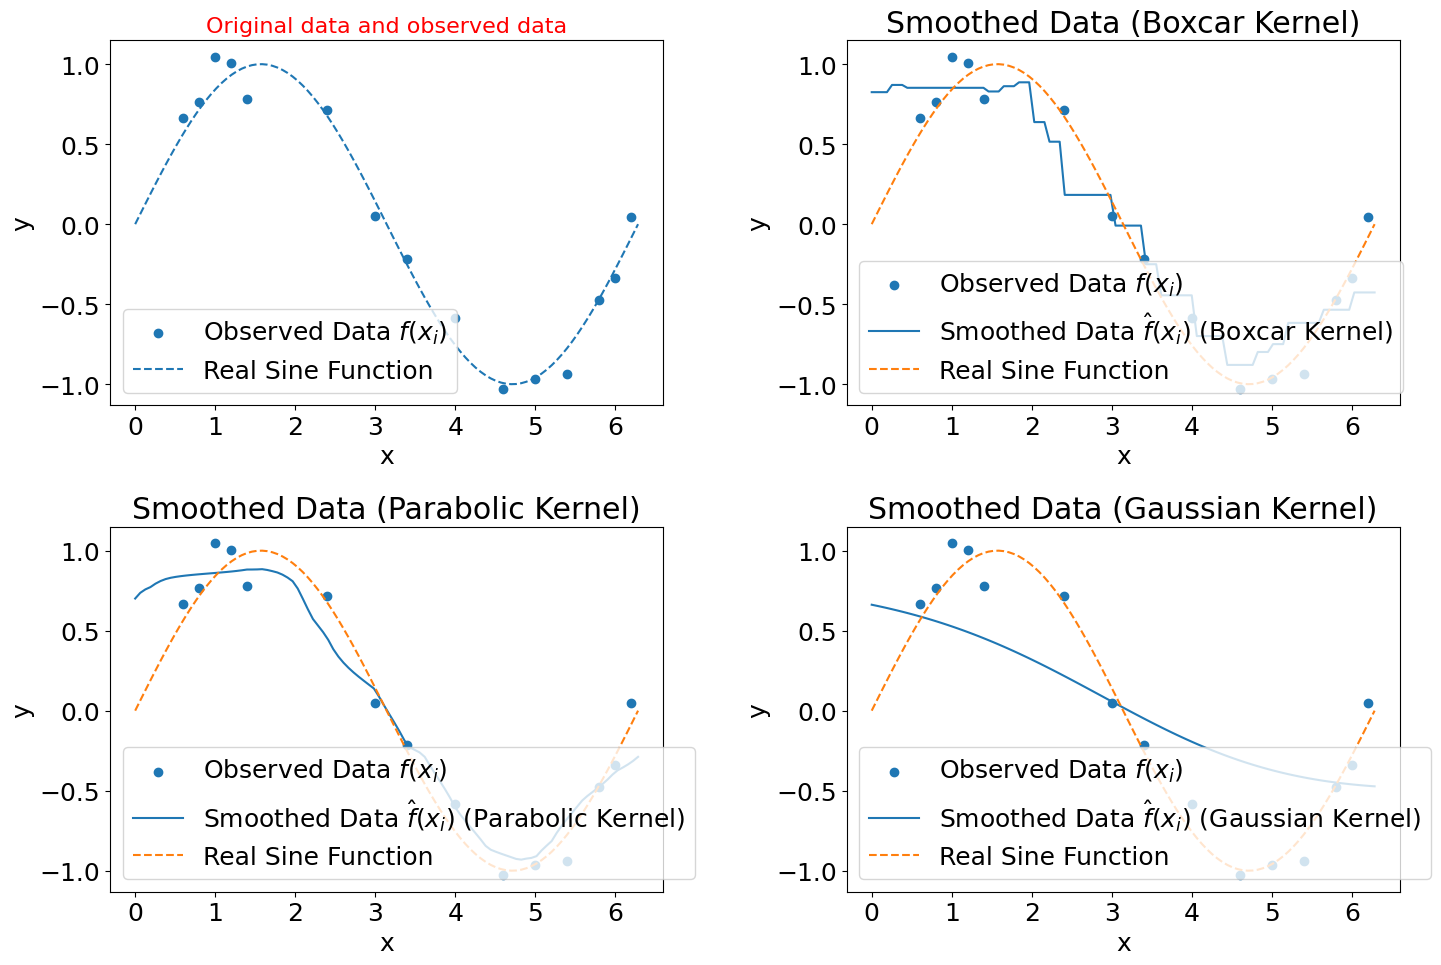

In [154]:

# Generate sparse sinusoidal dummy data
x_sparse, y_sparse = generate_sparse_sin_data(n_samples=15)

# Smooth the sparse data using Nadaraya-Watson kernel smoother
x_smooth = np.linspace(0, 2*np.pi, num=100)
y_smooth_gaussian = np.zeros_like(x_smooth)
y_smooth_boxcar = np.zeros_like(x_smooth)
y_smooth_parabolic = np.zeros_like(x_smooth)

for i in range(len(x_smooth)):
    y_smooth_gaussian[i] = nadaraya_watson_kernel_smoother(x_smooth[i], x_sparse, y_sparse, gaussian_kernel)
    y_smooth_boxcar[i] = nadaraya_watson_kernel_smoother(x_smooth[i], x_sparse, y_sparse, boxcar_kernel)
    y_smooth_parabolic[i] = nadaraya_watson_kernel_smoother(x_smooth[i], x_sparse, y_sparse, parabolic_kernel)


# Plotting
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Sparse Data
axs[0, 0].scatter(x_sparse, y_sparse, label=(r'Observed Data $f(x_i)$'))
axs[0, 0].plot(x_smooth, np.sin(x_smooth), linestyle='--', label='Real Sine Function')
axs[0, 0].set_title('Original data and observed data', fontsize=16, color='r')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('y')
axs[0, 0].legend(loc='lower left')

# Boxcar Kernel
axs[0, 1].scatter(x_sparse, y_sparse, label='Observed Data $f(x_i)$')
axs[0, 1].plot(x_smooth, y_smooth_boxcar, label='Smoothed Data $\hat{f}(x_i)$ (Boxcar Kernel)')
axs[0, 1].plot(x_smooth, np.sin(x_smooth), linestyle='--', label='Real Sine Function')
axs[0, 1].set_title('Smoothed Data (Boxcar Kernel)')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('y')
axs[0, 1].legend(loc='lower left')

# Gaussian Kernel
axs[1, 0].scatter(x_sparse, y_sparse, label='Observed Data $f(x_i)$')
axs[1, 0].plot(x_smooth, y_smooth_parabolic, label='Smoothed Data $\hat{f}(x_i)$ (Parabolic Kernel)')
axs[1, 0].plot(np.linspace(0, 2*np.pi, num=100), np.sin(np.linspace(0, 2*np.pi, num=100)), linestyle='--', label='Real Sine Function')
axs[1, 0].set_title('Smoothed Data (Parabolic Kernel)')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('y')
axs[1, 0].legend(loc='lower left')

axs[1, 1].scatter(x_sparse, y_sparse, label='Observed Data $f(x_i)$')
axs[1, 1].plot(x_smooth, y_smooth_gaussian, label='Smoothed Data $\hat{f}(x_i)$ (Gaussian Kernel)')
axs[1, 1].plot(np.linspace(0, 2*np.pi, num=100), np.sin(np.linspace(0, 2*np.pi, num=100)), linestyle='--', label='Real Sine Function')
axs[1, 1].set_title('Smoothed Data (Gaussian Kernel)')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('y')
axs[1, 1].legend(loc='lower left')

plt.tight_layout()
plt.show()

## Positional Embeddings
Learnable embeddings are simply torch parameters. They are initialized randomly and updated during training. The positional embeddings are added to the token embeddings before being fed into the encoder. The positional embeddings are also updated during training.

The sinusoidal positional embeddings are functions of the position index and the dimension index. The dimension index is the index of the dimension of the token embedding. The sinusoidal positional embeddings are pre-computed and are not updated during training.

In [136]:
learnable_pos_embedding = nn.Parameter(torch.randn(1, num_tokens, token_embed_dim))  # plus 1 for the <cls> token
x_token_w_learnable_pos_embedding = x_token + learnable_pos_embedding

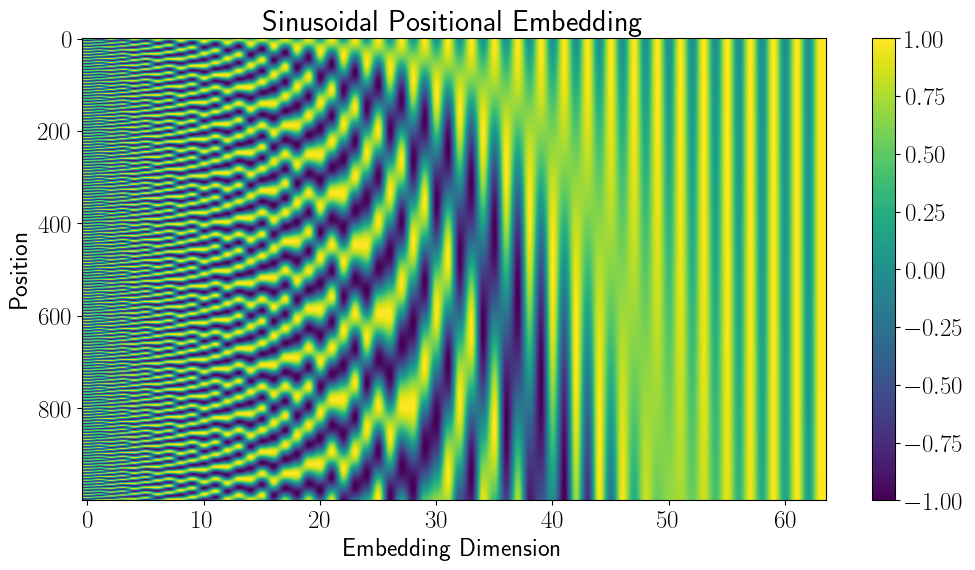

In [137]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class SinusoidalPositionalEmbedding(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.embed_dim = embed_dim
        inverse_frequency = 1. / (10000 ** (torch.arange(0, embed_dim, 2).float() / embed_dim))
        inverse_frequency = torch.unsqueeze(inverse_frequency, dim=0)  # unsequeeze for broadcasting to batches
        self.register_buffer('inverse_frequency', inverse_frequency)

    def forward(self, p):
        outer_product = torch.einsum('bn,nd->bnd', p, self.inverse_frequency)
        pos_emb = torch.stack([outer_product.sin(), outer_product.cos()], dim=-1)
        pos_emb = pos_emb.flatten(2)
        return pos_emb

# Create an instance of the SinusoidalPositionalEmbedding module
pos_emb_module = SinusoidalPositionalEmbedding(token_embed_dim)

# Generate positional embeddings for the sequence
positions = torch.arange(1000).unsqueeze(0)
sinusoidal_positional_embeddings = pos_emb_module(positions)

# Convert the tensor to numpy array for visualization
pos_emb_np = sinusoidal_positional_embeddings.squeeze(0).numpy()

# Plot the sinusoidal positional embedding
plt.figure(figsize=(12, 6))
plt.imshow(pos_emb_np, cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel('Embedding Dimension')
plt.ylabel('Position')
plt.title('Sinusoidal Positional Embedding')
plt.show()

## Transformer for classification

Let's first define production code for a transformer.

In [138]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attention = self.attend(dots)
        attention = self.dropout(attention)  # TODO

        out = torch.matmul(attention, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out), attention


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, feedforward_mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, feedforward_mlp_dim, dropout=dropout))
            ]))

    def forward(self, x):
        for prenorm_attention, prenorm_feedforward in self.layers:
            out, attention = prenorm_attention(x)
            x = out + x
            x = prenorm_feedforward(x) + x
        return x, attention  # last layer


class PhysioTransformer(nn.Module):
    def __init__(self, num_timesteps, num_channels, sampling_rate, num_classes, depth=4, num_heads=8, feedforward_mlp_dim=32, window_duration=0.1, pool='cls',
                 patch_embed_dim=128, dim_head=64, attn_dropout=0.5, emb_dropout=0.5, output='multi'):
        """

        # a token is a time slice of data on a single channel

        @param num_timesteps: int: number of timesteps in each sample
        @param num_channels: int: number of channels of the input data
        @param output: str: can be 'single' or 'multi'. If 'single', the output is a single number to be put with sigmoid activation. If 'multi', the output is a vector of size num_classes to be put with softmax activation.
        note that 'single' only works when the number of classes is 2.
        """
        if output == 'single':
            assert num_classes == 2, 'output can only be single when num_classes is 2'
        super().__init__()
        self.depth = depth
        self.num_heads = num_heads
        self.window_duration = window_duration

        self.num_channels = num_channels
        self.num_timesteps = num_timesteps
        self.path_embed_dim = patch_embed_dim
        self.patch_length = int(window_duration * sampling_rate)
        self.num_windows = num_timesteps // self.patch_length

        self.grid_dims = self.num_channels, self.num_windows
        self.num_patches = self.num_channels * self.num_windows

        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c t -> b 1 c t', c=self.num_channels, t=self.num_timesteps),
            nn.Conv2d(1, patch_embed_dim, kernel_size=(1, self.patch_length), stride=(1, self.patch_length), bias=True),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, patch_embed_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, patch_embed_dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(patch_embed_dim, depth, num_heads, dim_head, feedforward_mlp_dim, attn_dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        if output == 'single':
            self.mlp_head = nn.Sequential(
                nn.LayerNorm(patch_embed_dim),
                nn.Linear(patch_embed_dim, 1))
        else:
            self.mlp_head = nn.Sequential(
                nn.LayerNorm(patch_embed_dim),
                nn.Linear(patch_embed_dim, num_classes))

    def forward(self, x_eeg):
            x = self.encode(x_eeg)
            return self.mlp_head(x)

    def encode(self, x_eeg):
        x = self.to_patch_embedding(x_eeg)
        x = x.flatten(2).transpose(1, 2)  # BCHW -> BNC

        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x, att_matrix = self.transformer(x)
        x = x.mean(dim=1) if self.pool == 'mean' else x[:, 0]
        x = self.to_latent(x)
        return x

In [139]:
data_x_path = 'C:/Data/x_auditory_oddball.p'
data_y_path = 'C:/Data/y_auditory_oddball.p'

with open(data_x_path, 'rb') as f:
    data_x = pickle.load(f)
with open(data_y_path, 'rb') as f:
    data_y = pickle.load(f)

print(f"{data_x.shape = }")
print(f"{data_y.shape = }")

for class_label in np.unique(data_y):
    print(f"{class_label = } {np.sum(data_y == class_label) = }")

data_x.shape = (23502, 64, 180)
data_y.shape = (23502,)
class_label = 0 np.sum(data_y == class_label) = 19836
class_label = 6 np.sum(data_y == class_label) = 3666


In [140]:
def z_norm_by_trial(data):
    """
    Z-normalize data by trial, the input data is in the shape of (num_samples, num_channels, num_timesteps)
    @param data: data is in the shape of (num_samples, num_channels, num_timesteps)
    """
    norm_data = np.copy(data)
    for i in range(data.shape[0]):
        sample = data[i]
        mean = np.mean(sample, axis=(0, 1))
        std = np.std(sample, axis=(0, 1))
        sample_norm = (sample - mean) / std
        norm_data[i] = sample_norm
    return norm_data

print(f"before z norm: {np.mean(data_x).round(3) = }, {np.std(data_x).round(3) = }")
data_x = z_norm_by_trial(data_x)
print("after z norm: ", np.mean(data_x).round(3), np.std(data_x).round(3))

before z norm: np.mean(data_x).round(3) = -0.0, np.std(data_x).round(3) = 0.0
after z norm:  0.0 1.0


In [141]:

# rebalance our data
def rebalance_classes(x, y, by_channel=False, random_seed=None):
    """
    Resamples the data to balance the classes using SMOTE algorithm.

    Parameters:
        x (np.ndarray): Input data array of shape (epochs, channels, samples).
        y (np.ndarray): Target labels array of shape (epochs,).
        by_channel (bool): If True, balance the classes separately for each channel. Otherwise,
            balance the classes for the whole input data.

    Returns:
        tuple: A tuple containing the resampled input data and target labels as numpy arrays.
    """
    epoch_shape = x.shape[1:]

    if by_channel:
        y_resample = None
        channel_data = []
        channel_num = epoch_shape[0]

        # Loop through each channel and balance the classes sepairately
        for channel_index in range(0, channel_num):
            sm = SMOTE(random_state=random_seed)
            x_channel = x[:, channel_index, :]
            x_channel, y_resample = sm.fit_resample(x_channel, y)
            channel_data.append(x_channel)

        # Expand dimensions for each channel array and concatenate along the channel axis
        channel_data = [np.expand_dims(x, axis=1) for x in channel_data]
        x = np.concatenate([x for x in channel_data], axis=1)
        y = y_resample

    else:
        # Reshape the input data to 2D array and balance the classes
        x = np.reshape(x, newshape=(len(x), -1))
        sm = SMOTE(random_state=random_seed)
        x, y = sm.fit_resample(x, y)

        # Reshape the input data back to its original shape
        x = np.reshape(x, newshape=(len(x),) + epoch_shape)

    return x, y

data_x, data_y = rebalance_classes(data_x, data_y, by_channel=False, random_seed=42)


for class_label in np.unique(data_y):
    print(f"{class_label = } {np.sum(data_y == class_label) = }")

class_label = 0 np.sum(data_y == class_label) = 19836
class_label = 6 np.sum(data_y == class_label) = 19836


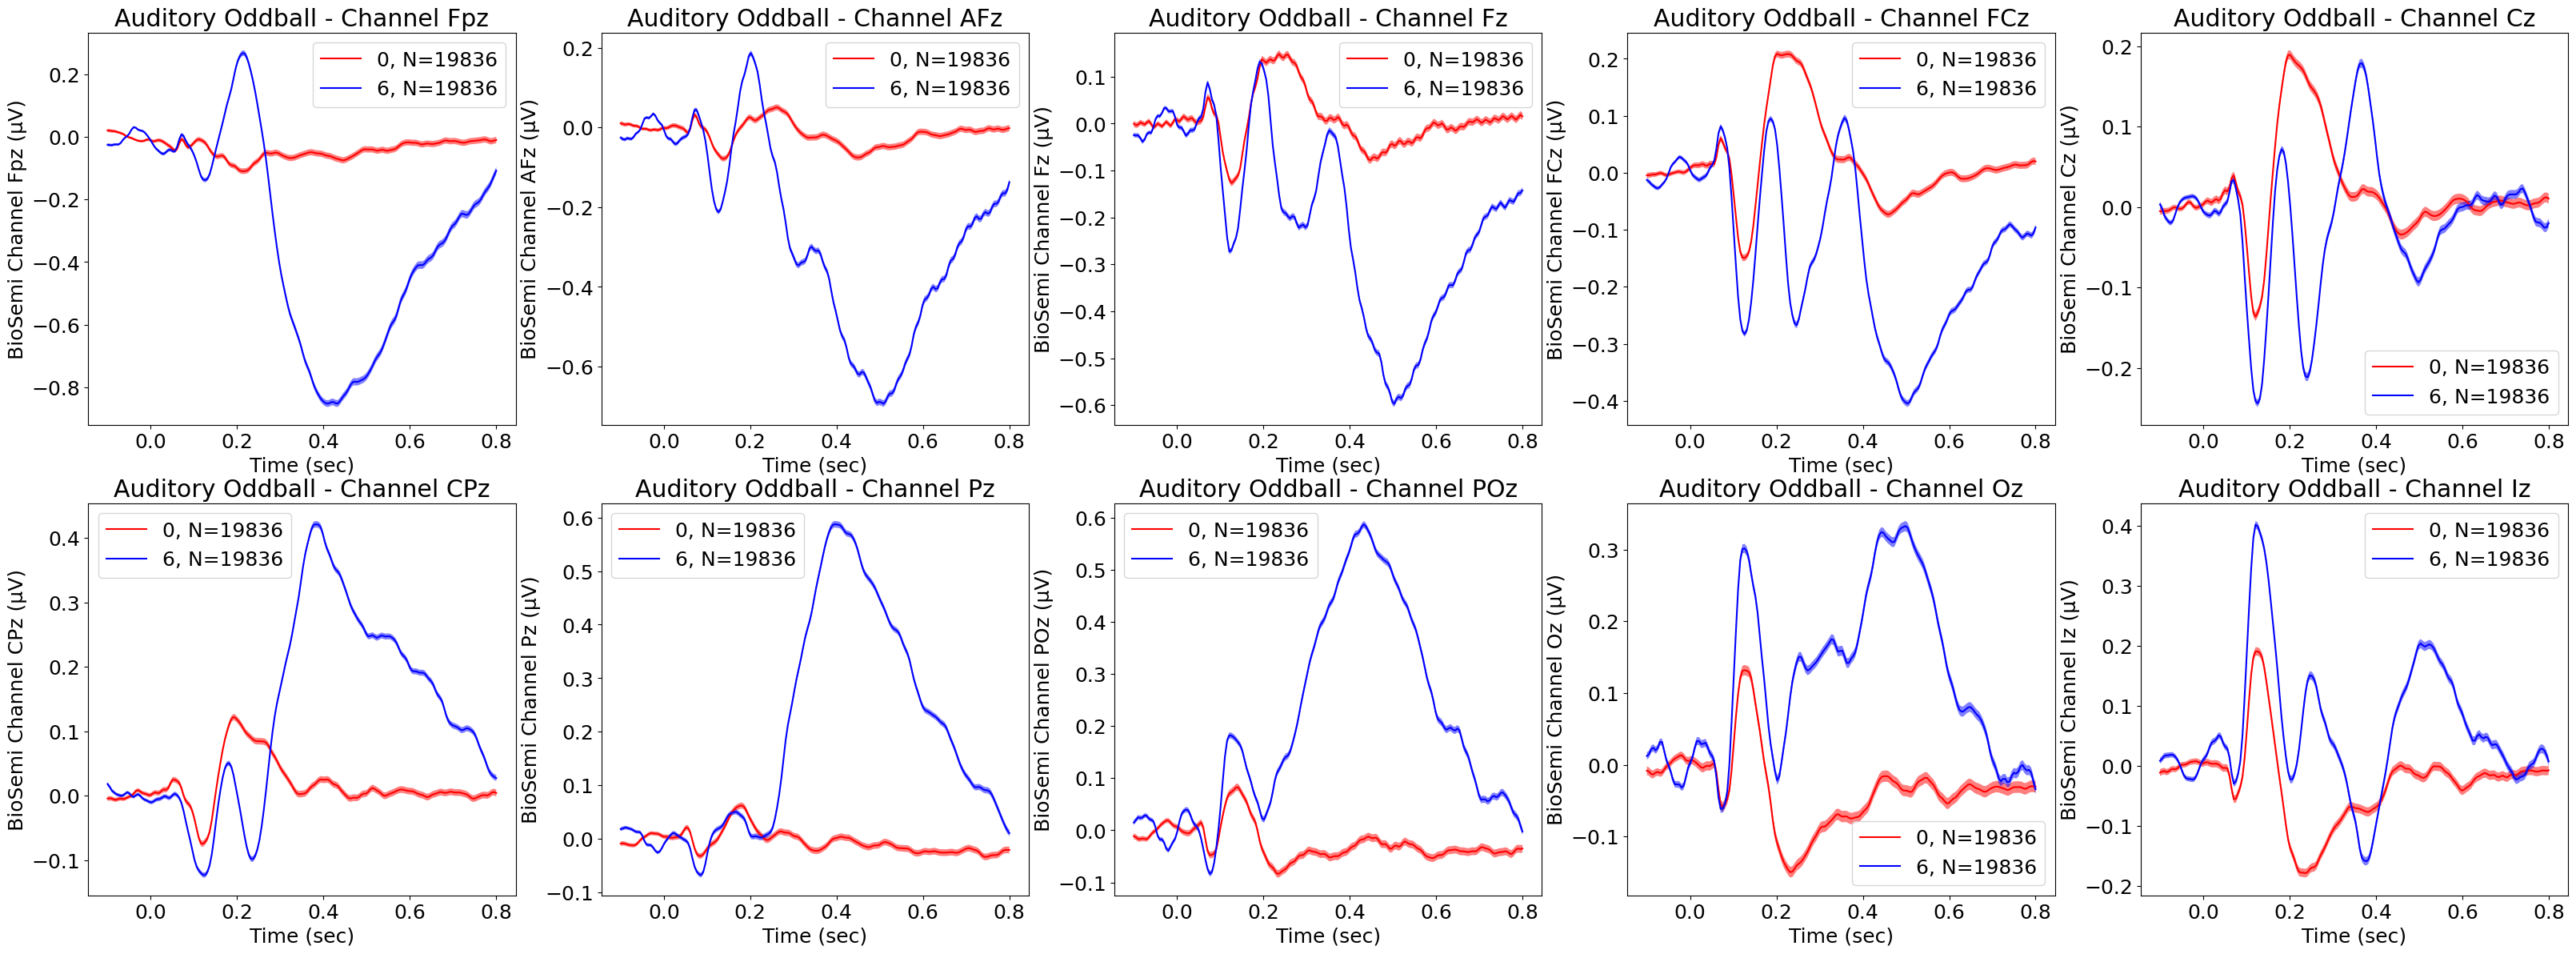

In [142]:
def visualize_eeg_samples(x, y, colors, eeg_picks, title='',
                          is_plot_timeseries=True, xeeg_tmin=-0.1, xeeg_tmax=0.8, nrows=2):
    ncols = len(eeg_picks) // nrows
    fig_size = (ncols * 8, nrows * 7)
    plt.rcParams["figure.figsize"] = fig_size
    event_ids = set(y)
    x = np.swapaxes(np.copy(x), 0, 1)
    # Plot each EEG channel for each event type
    if is_plot_timeseries:
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, squeeze=True)
        for i, (ch, ch_index) in enumerate(eeg_picks.items()):
            ax_index = np.unravel_index(i, (nrows, ncols))
            for event in event_ids:
                event_idx = np.where(y == event)[0]
                x_mean = np.mean(x[ch_index][event_idx], axis=0)
                x1 = x_mean + stats.sem(x[ch_index][event_idx], axis=0)  # this is the upper envelope
                x2 = x_mean - stats.sem(x[ch_index][event_idx], axis=0)
                time_vector = np.linspace(xeeg_tmin, xeeg_tmax, x[ch_index][event_idx].shape[-1])
                # Plot the EEG data as a shaded area
                ax[ax_index].fill_between(time_vector, x1, x2, where=x2 <= x1, facecolor=colors[event], interpolate=True,
                                 alpha=0.5)
                ax[ax_index].plot(time_vector, x_mean, c=colors[event], label='{0}, N={1}'.format(event, x[ch_index][event_idx].shape[0]))

                # Set the labels and title for the plot
            ax[ax_index].set_xlabel('Time (sec)')
            ax[ax_index].set_ylabel('BioSemi Channel {0} (μV)'.format(ch))
            ax[ax_index].legend()
            ax[ax_index].set_title('{0} - Channel {1}'.format(title, ch))
    plt.show()


plt.rcParams['text.usetex'] = False

colors = {0: 'red', 6: 'blue'}
montage = mne.channels.make_standard_montage('biosemi64')
visualize_channel_picks = ['Fpz', 'AFz', 'Fz', 'FCz', 'Cz', 'CPz', 'Pz', 'POz', 'Oz',  'Iz']
eeg_picks = {ch_name: montage.ch_names.index(ch_name) for ch_name in visualize_channel_picks}

visualize_eeg_samples(data_x, data_y, colors, eeg_picks, title='Auditory Oddball', is_plot_timeseries=True)

In [143]:
label_onehot_encoder = preprocessing.OneHotEncoder()
y_encoded = label_onehot_encoder.fit_transform(data_y.reshape(-1, 1)).toarray()

print(f"{np.unique(data_y) = }")
print(f"{np.unique(y_encoded, axis=0) = }")

np.unique(data_y) = array([0, 6])
np.unique(y_encoded, axis=0) = array([[0., 1.],
       [1., 0.]])


In [103]:
_, num_channels, num_timesteps = data_x.shape
sampling_rate = 200
model = PhysioTransformer(num_timesteps=num_timesteps, num_channels=num_channels, sampling_rate=sampling_rate, num_classes=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 4.432MB


In [ ]:

# Set device

# Split the data into training and validation sets
x_train, x_val, y_train_encoded, y_val_encoded = train_test_split(data_x, y_encoded, test_size=0.2, random_state=42, shuffle=True, stratify=y_encoded)

# Convert the data into PyTorch tensors
x_train = torch.Tensor(x_train)
x_val = torch.Tensor(x_val)
y_train_encoded = torch.Tensor(y_train_encoded)
y_val_encoded = torch.Tensor(y_val_encoded)

# Define hyperparameters
batch_size = 32
lr = 0.0001
num_epochs = 1
l2_weight = 1e-5

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
last_activation = nn.Softmax(dim=1)

optimizer = optim.Adam(model.parameters(), lr=lr)

train_dataset = TensorDataset(x_train, y_train_encoded)
val_dataset = TensorDataset(x_val, y_val_encoded)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

file_path = 'model.pt'

### The training loop

In [ ]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = []
    num_correct_preds = 0
    pbar = tqdm(total=len(train_dataloader), desc=f'Epoch {epoch+1}/{num_epochs} training', unit="batch")
    for x, y in train_dataloader:
        y_tensor = y.to(device)
        # Forward pass
        outputs = model(x.to(device))
        y_pred = last_activation(outputs)
        loss = criterion(y_pred, y_tensor)
        l2_penalty = l2_weight * sum([(p ** 2).sum() for p in model.parameters()])
        loss += l2_penalty
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())

        # Calculate training predictions for accuracy calculation
        preds = torch.argmax(y_pred, dim=1).detach().cpu().numpy()

        predicted_labels = torch.argmax(y_pred, dim=1)
        true_label = torch.argmax(y_tensor, dim=1)
        num_correct_preds += torch.sum(true_label == predicted_labels).item()

        # Update progress bar description with loss
        pbar.update(1)
        pbar.set_postfix(loss=loss.item())
    pbar.close()
    scheduler.step()

    # Compute the average training loss for the epoch
    avg_loss = np.mean(running_loss)

    # Calculate training accuracy
    train_acc = num_correct_preds / len(train_dataset)

    # Evaluate on the validation set
    model.eval()
    val_running_loss = []
    num_correct_preds = 0
    val_preds = []
    with torch.no_grad():
        pbar = tqdm(total=len(val_dataloader), desc=f'Epoch {epoch + 1}/{num_epochs} validating', unit="batch")
        for x, y in val_dataloader:
            y_tensor = y.to(device)
            # Forward pass
            outputs = model(x.to(device))
            y_pred = last_activation(outputs)
            loss = criterion(y_pred, y_tensor)

            val_running_loss.append(loss.item())

            # Calculate training predictions for accuracy calculation
            preds = torch.argmax(y_pred, dim=1).detach().cpu().numpy()

            predicted_labels = torch.argmax(y_pred, dim=1)
            true_label = torch.argmax(y_tensor, dim=1)
            num_correct_preds += torch.sum(true_label == predicted_labels).item()

            # Update progress bar description with loss
            pbar.update(1)
            pbar.set_postfix(loss=loss.item())
    pbar.close()

    # Compute the average validation loss
    val_avg_loss = np.mean(val_running_loss)
    # Calculate validation accuracy
    val_acc = num_correct_preds / len(val_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_avg_loss:.4f}, Val Acc: {val_acc:.4f}")

print("Training finished!")

# torch.save(model.state_dict(), file_path)

## Load the model if needed

In [104]:
model = PhysioTransformer(num_timesteps=num_timesteps, num_channels=num_channels, sampling_rate=sampling_rate, num_classes=2)
model.load_state_dict(torch.load(file_path))

<All keys matched successfully>

## Visualize the model's attention map

In [105]:
def rollout(depth, attentions, discard_ratio, head_fusion, token_shape):
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for i, attention in enumerate(attentions):
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            elif head_fusion == "None":
                pass
            else:
                raise "Attention head fusion type Not supported"

            # Drop the lowest attentions, but don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1) * discard_ratio), -1, False)
            indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-2), attention_heads_fused.size(-1))  # TODO check why this is not square for ExpertAttentionModel
            a = (attention_heads_fused + 1.0 * I) / 2
            a = a / a.sum(dim=-1)

            result = torch.matmul(a, result)
            if i == depth:
                break

    # Look at the total attention between the class token,
    # and the tokens
    mask = result[0, 0, 1:]
    # In case of 224x224 image, this brings us from 196 to 14
    mask = mask.reshape(token_shape).numpy()
    mask = mask / np.max(mask)
    return mask


class VITAttentionRollout:
    def __init__(self, model, device, attention_layer_class, token_shape, head_fusion="mean", discard_ratio=0.9):
        self.model = model
        self.device = device
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        self.token_shape = token_shape

        self.attention_layer_count = 0
        for name, module in self.model.named_modules():
            if isinstance(module, attention_layer_class):  # HT's attention layer
                module.register_forward_hook(self.get_attention)
                self.attention_layer_count += 1
        if self.attention_layer_count == 0:
            raise ValueError("No attention layer in the given model")
        if self.attention_layer_count != self.model.depth:
            raise ValueError(f"Model depth ({self.model.depth}) does not match attention layer count {self.attention_layer_count}")
        self.attentions = []

    def get_attention(self, module, input, output):
        attention_output = output
        self.attentions.append(attention_output[1].cpu())

    def __call__(self, depth, input_tensor, fix_sequence=None):
        if depth > self.attention_layer_count:
            raise ValueError(f"Given depth ({depth}) is greater than the number of attenion layers in the model ({self.attention_layer_count})")
        self.attentions = []
        self.model.eval()

        output = self.model(input_tensor.to(self.device))

        return rollout(depth, self.attentions, self.discard_ratio, self.head_fusion, token_shape=self.token_shape)

In [118]:
def attention_viz(model: Union[str, PhysioTransformer], X, Y, y_encoder, event_names,
           data_root,
           split_window_eeg, exg_resample_rate, eeg_montage, num_timesteps=None, num_channels=None,
           note='',
           head_fusion='max', discard_ratio=0.1,
           load_saved_rollout=False, batch_size=64,
           X_pca_ica=None, pca=None, ica=None):
    """
    @param num_channels: number of channels for the model. This can be different from the number of channels in X. If they are different,
    we assume the model is using dimension reduced data.
    @param X_pca_ica: if None, assume model is not using dimension reduced data
    """
    event_ids = {event_name: event_id for event_id, event_name in zip(np.sort(np.unique(Y)), event_names)}
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if isinstance(model, str):
        assert num_timesteps is not None and num_channels is not None, "Must provide num_timesteps and num_channels if model is a path"
        assert os.path.exists(model), "Model path does not exist"
        model_path = model  # save the model path
        model = PhysioTransformer(num_timesteps, num_channels, exg_resample_rate, num_classes=2)
        model.load_state_dict(torch.load(model_path))
    model.to(device)
    window_size = model.patch_length
    eeg_channel_names = mne.channels.make_standard_montage('biosemi64').ch_names
    info = mne.create_info(eeg_channel_names, sfreq=exg_resample_rate, ch_types=['eeg'] * len(eeg_channel_names))
    info.set_montage(eeg_montage)

    rollout_fname = f'HT-rollout_{note}.pkl'
    rollout_x_fname = f'HT-rollout_x_{note}.pkl'
    rollout_y_fname = f'HT-rollout_y_{note}.pkl'

    activations = defaultdict(list)
    if load_saved_rollout:
        with open(os.path.join(data_root, rollout_fname), 'rb') as f:
            rolls = pickle.load(f)
        with open(os.path.join(data_root, rollout_x_fname), 'rb') as f:
            _x = pickle.load(f)
        with open(os.path.join(data_root, rollout_y_fname), 'rb') as f:
            _y = pickle.load(f)
    else:
        # x_train, x_test, y_train, y_test = X[train], X[test], Y[train], Y[test]
        # x_train, y_train = rebalance_classes(x_train, y_train)  # rebalance by class

        # train_size, val_size = len(x_train), len(x_test)
        # x_train = torch.Tensor(x_train)  # transform to torch tensor
        # x_test = torch.Tensor(x_test)
        #
        # y_train = torch.Tensor(y_train)
        # y_test = torch.Tensor(y_test)

        rollout = VITAttentionRollout(model, device, attention_layer_class=Attention, token_shape=model.grid_dims, discard_ratio=discard_ratio, head_fusion=head_fusion)
        Y_encoded = y_encoder(Y)
        Y_encoded_tensor = torch.Tensor(Y_encoded).to(device)
        X_tensor = torch.Tensor(X).to(device)

        if X_pca_ica is not None:
            X_pca_ica_tensor = torch.Tensor(X_pca_ica).to(device)
        else:  # otherwise just duplicate the X_tensor
            X_pca_ica_tensor = X_tensor
        dataset = TensorDataset(X_tensor, X_pca_ica_tensor, Y_encoded_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size)
        val_size = len(dataset)

        rolls = defaultdict(list)
        _y = []
        _x = []
        for i, (x, x_pca_ica, y) in enumerate(dataloader):
            print(f"Rolling out attention for batch {i} of {val_size // batch_size}")
            for j, (single_x, single_x_pca_ica) in enumerate(zip(x, x_pca_ica)): # one sample at a time
                print(f"Working on sample {j} of {len(x)}")
                for roll_depth in range(model.depth):
                    with torch.no_grad():
                        x_data = single_x.unsqueeze(0) if X_pca_ica is None else single_x_pca_ica.unsqueeze(0)
                        # rolls[roll_depth].append(rollout(depth=roll_depth, input_tensor=x_data))

                        roll = rollout(depth=roll_depth, input_tensor=x_data)
                        roll_tensor = torch.Tensor(roll).to(device)
                        forward_activation = torch.empty((X.shape[1] if X_pca_ica is None else X_pca_ica.shape[1], model.num_windows, model.patch_length))
                        # if roll.shape[0] != X.shape[1]:  # HT is using dimension-reduced input

                        # compute forward activation
                        single_x_windowed = torch.chunk(single_x, model.num_windows, dim=1) if X_pca_ica is None else torch.chunk(single_x_pca_ica, model.num_windows, dim=1)
                        for window_i, x_window_data in enumerate(single_x_windowed):
                            roll_tensor_window = roll_tensor[:, window_i]
                            denom = torch.matmul(roll_tensor_window.T, roll_tensor_window)
                            if denom == 0:
                                forward_activation[:, window_i] = 0
                            else:
                                # forward_solution_pca_ica = torch.matmul(x_window_data.T, roll_tensor_window) / denom
                                forward_window = x_window_data * roll_tensor_window.view(-1, 1) / denom
                                forward_activation[:, window_i, :] = forward_window
                        if X_pca_ica is not None:
                            activation_reshaped = forward_activation.reshape((-1, model.num_windows * model.patch_length))[None, :]
                            forward_activation = pca.inverse_transform(ica.inverse_transform(activation_reshaped))[0]
                            forward_activation = forward_activation.reshape((-1, model.num_windows, model.patch_length))

                        activations[roll_depth].append(forward_activation)
                        rolls[roll_depth].append(roll)
            if i == 1: break
            _y.append(y.cpu().numpy())
            _x.append(x.cpu().numpy())
        _x = np.concatenate(_x)
        _y = np.concatenate(_y)

        # save the rollout
        with open(os.path.join(data_root, rollout_fname), 'wb') as f:
            pickle.dump(rolls, f)
        with open(os.path.join(data_root, rollout_x_fname), 'wb') as f:
            pickle.dump(_x, f)
        with open(os.path.join(data_root, rollout_y_fname), 'wb') as f:
            pickle.dump(_y, f)

    # plot the topomap
    fig = plt.figure(figsize=(22, 10), constrained_layout=True)
    subfigs = fig.subfigures(2, 1)
    x_mean_max = np.max(np.mean(_x, axis=(0, -1)))
    for class_index, (e_name, e_id) in enumerate(event_ids.items()):
        axes = subfigs[class_index].subplots(1, model.num_windows, sharey=True)
        y_event = np.squeeze(y_encoder(np.array([e_id])[np.newaxis, :]))
        _x_class = _x[np.all(_y == y_event, axis=1)]
        for window_i in range(model.num_windows):
            _x_class_window = _x_class[:, :, (window_i) * window_size:(window_i + 1) * window_size]
            _x_mean = np.mean(_x_class_window, axis=(0, -1))

            plot_topomap(_x_mean, info, axes=axes[window_i - 1], show=False, res=512, vlim=(0, x_mean_max))
            # plot_topomap(activation, info, axes=axes[window_i - 1], show=False, res=512, vlim=(np.min(this__roll), np.max(this_roll)))
            axes[window_i - 1].set_title(
                f"{int((window_i - 1) * split_window_eeg * 1e3)}-{int(window_i * split_window_eeg * 1e3)}ms")
        subfigs[class_index].suptitle(e_name, )
    fig.suptitle(f"EEG topomap, {note}", fontsize='x-large')
    plt.show()

    for roll_depth in range(model.depth):
        this_roll = np.stack(rolls[roll_depth], axis=0)
        this_activation = np.stack(activations[roll_depth], axis=0)

        fig = plt.figure(figsize=(15, 10))
        # cross_window_activates = mean_ignore_zero(this_roll, axis=1)
        # cross_window_activates = np.true_divide(this_roll.sum(axis=1), (this_roll != 0).sum(axis=1))
        across_channel_rolls = np.sum(this_roll, axis=1)  # finding activates across channels

        plt.boxplot(across_channel_rolls)
        x_labels = [f"{int((i - 1) * split_window_eeg * 1e3)}ms" for i in range(model.num_windows)]
        x_ticks = np.arange(0.5, model.num_windows + 0.5, 1)
        plt.twinx()
        plt.plot(list(range(1, model.num_windows + 1)), np.sum(across_channel_rolls, axis=0), label=f"Sum across samples")
        # plt.plot(list(range(1, model.num_windows + 1)), mean_ignore_zero(cross_window_activates, axis=0), label="Max across samples")

        plt.xticks(ticks=x_ticks, labels=x_labels)
        plt.xlabel("100 ms windowed bins")
        plt.ylabel("Cross-window attention activation")
        plt.title(f'Cross-window attention, {note}, HT depth {roll_depth+1} of {model.depth}')
        plt.legend()
        plt.tight_layout()
        plt.show()

        fig = plt.figure(figsize=(22, 10))
        subfigs = fig.subfigures(2, 1)

        # plot the topomap rollouts
        for class_index, (e_name, e_id) in enumerate(event_ids.items()):
            axes = subfigs[class_index].subplots(1, model.num_windows, sharey=True)
            y_event = np.squeeze(y_encoder(np.array([e_id])[np.newaxis, :]))
            activation_class = this_activation[np.all(_y == y_event, axis=1)]
            # activation_max = np.max(np.sum(activation_class, axis=0))
            # activation_min = np.min(np.sum(activation_class, axis=0))
            for window_i in range(model.num_windows):
                forward_activation = activation_class[:, :, window_i]
                forward_activation = np.sum(forward_activation, axis=0)
                forward_activation = np.mean(forward_activation, axis=1)
                # activation_max = np.max(forward_activation)

                activation_max = np.max(forward_activation, axis=0)
                activation_min = np.min(forward_activation, axis=0)

                plot_topomap(forward_activation, info, axes=axes[window_i - 1], show=False, res=512, vlim=(activation_min, activation_max))
                # plot_topomap(activation, info, axes=axes[window_i - 1], show=False, res=512, vlim=(np.min(this__roll), np.max(this_roll)))
                axes[window_i - 1].set_title(f"{int((window_i - 1) * split_window_eeg * 1e3)}-{int(window_i * split_window_eeg * 1e3)}ms")
            subfigs[class_index].suptitle(e_name, )

        fig.suptitle(f"Attention to the CLS token: {note}, HT depth {roll_depth+1} of {model.depth}", fontsize='x-large')
        plt.show()

Text(0.5, 1.0, 'attention matrix at depth 4')

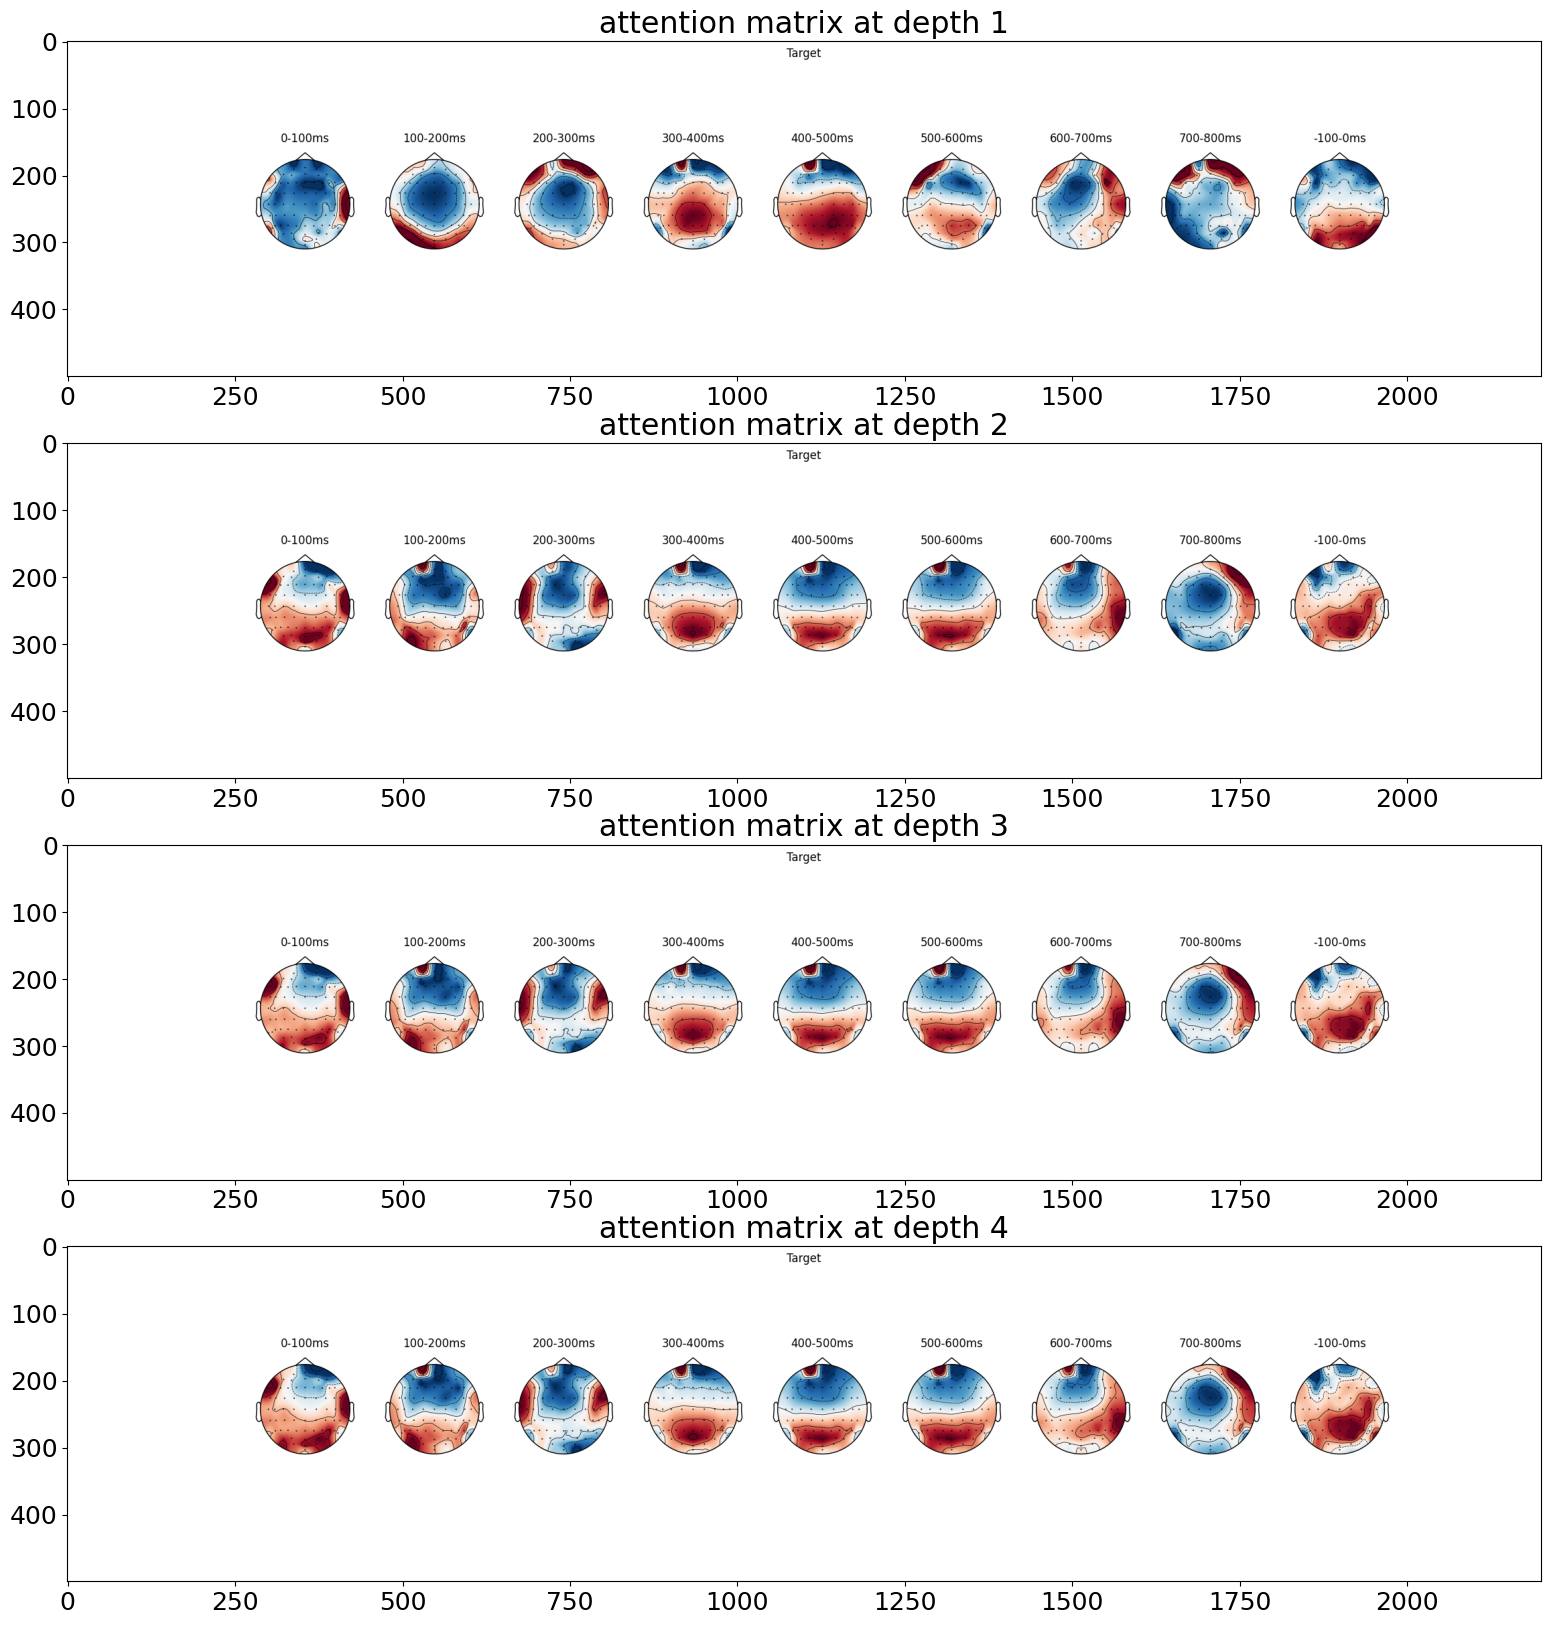

In [125]:
encoder_func = lambda y: label_onehot_encoder.transform(y.reshape(-1, 1)).toarray()
rollout_data_root = f'HT_viz'
event_names =  ["Distractor", "Target with response"]

attention_viz(model, x_val.detach().numpy(), label_onehot_encoder.inverse_transform(y_val_encoded.detach().numpy()), encoder_func, event_names, rollout_data_root,
       model.window_duration,
       sampling_rate,
       montage, num_timesteps, num_channels, note='', load_saved_rollout=True, head_fusion='max',
       discard_ratio=0.9, batch_size=32)
